# BayeSQP on a constrained BoTorch benchmark


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from botorch.test_functions.synthetic import ConstrainedHartmannSmooth

from bayesqp import BayeSQP, seed_everything

%matplotlib inline

In [2]:
DIM = 6

LB = 0.0
UB = 1.0

func = ConstrainedHartmannSmooth(dim=DIM)
func.bounds[0, :].fill_(LB)
func.bounds[1, :].fill_(UB)

# These are all algorithm settings
general_config = {
    "tol": 1e-4,
    "local_sample_strategy": "sobol_sphere",
    "clamp_to_bounds": True,  # enforce bounds at all times
    "generate_local_samples_after_step": True,
    "K": "auto",  # auto: (DIM+1), int
    "n_initial": DIM,  # initial samples
    "delta_f": 0.4,
    "delta_c": 0.4,
    "epsilon": 0.05,
}

line_search_config = {
    "min_alpha": 0.0,
    "max_alpha": 1.0,
    "method": "posterior_sampling",
    "n_candidates": 100,
    "M": 3,
}

bayesqp = BayeSQP(
    objective_function=func,
    verbose_level=-1,  # -1: silent, 0: normal 1: normal + warnings, 2: debug
    general_config=general_config,
    line_search_config=line_search_config,
)

In [3]:
seed_everything(0)  # 0 is an interesting seed; only valid reason not to use 42

# Define starting point
x0 = torch.rand(DIM).reshape(1, -1)

# Run optimization
result = bayesqp.minimize(x0, max_evals=100)

/Users/paulbrunzema/Documents/02_Code_Bases/bayesqp/.venv/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/paulbrunzema/Documents/02_Code_Bases/bayesqp/.venv/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


In [4]:
print(result)

BayeSQP Optimization Result

Optimization Status:
  Feasible:        ✓ Yes
  Function Evals:  100

Best Solution:
  Objective Value: -3.322355e+00
  Solution (x):    [0.2023, 0.1497, ..., 0.3116, 0.6576]  (dim=6)
  Best solution obtained at eval #98

Total Time: 8.0910 seconds


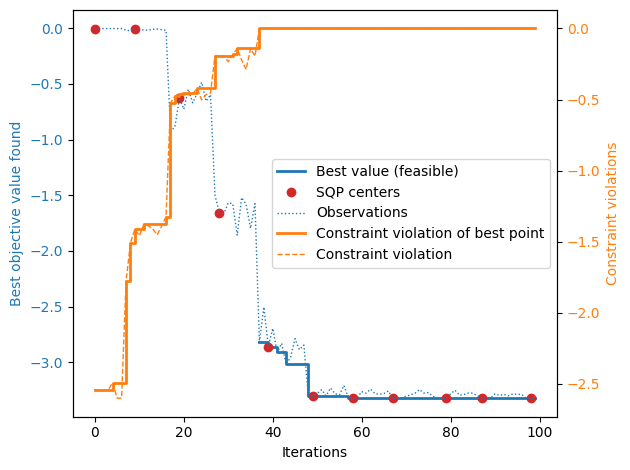

In [5]:
history = result.fun_history
x_history = result.x_history
step_x_history = result.step_history
is_feasible_history = result.feasible_history
constraint_values = np.array(result.constraint_values)

step_counter = 0
step_indieces = []

for i in range(len(x_history)):
    if np.allclose(x_history[i], step_x_history[step_counter]):
        step_indieces.append(i)
        step_counter += 1
        if step_counter >= len(step_x_history):
            break


fig, ax1 = plt.subplots()

# --- Primary axis (objective values)
n_evals = np.arange(0, len(history))
best_feasible_values = np.full_like(history, np.inf)
current_best = np.inf
for i in range(len(history)):
    if is_feasible_history[i] and history[i] < current_best:
        current_best = history[i]
    best_feasible_values[i] = current_best

best_values = best_feasible_values
ax1.step(
    n_evals,
    best_values,
    color="tab:blue",
    lw=2,
    where="post",
    label="Best value (feasible)",
)

ax1.plot(
    n_evals[step_indieces],
    history[step_indieces],
    color="tab:red",
    linestyle="None",
    marker="o",
    label="SQP centers",
)
ax1.plot(
    n_evals,
    history,
    color="tab:blue",
    linestyle="dotted",
    lw=1,
    label="Observations",
)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Best objective value found", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# --- Secondary axis (constraint violations)
ax2 = ax1.twinx()
if constraint_values.ndim == 1:
    constraint_values = constraint_values.reshape(-1, 1)

# best feasible constraint violation per iteration
constraint_values = np.minimum(constraint_values, 0)

constraint_violations = np.sum(constraint_values, axis=1)
best_constraint_violations = np.maximum.accumulate(constraint_violations)

ax2.step(
    n_evals,
    best_constraint_violations,
    color="tab:orange",
    lw=2,
    where="post",
    label="Constraint violation of best point",
)
ax2.plot(
    n_evals,
    constraint_violations,
    color="tab:orange",
    lw=1,
    linestyle="dashed",
    label="Constraint violation",
)
ax2.set_ylabel("Constraint violations", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# --- Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.tight_layout()
plt.show()

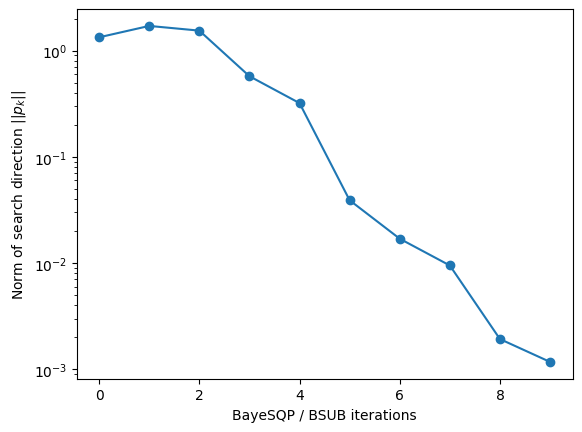

In [6]:
directions = result.info.directions
norms_pk = np.linalg.norm(directions, axis=1)
plt.plot(np.arange(len(norms_pk)), norms_pk, marker="o")
plt.xlabel("BayeSQP / BSUB iterations")
plt.yscale("log")
plt.ylabel("Norm of search direction $||p_k||$")
plt.show()